In [3]:
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import networkx as nx

## **Functions**

To start off, I define some functions that we use throughout the notebook. 

### **Graph Functions**

First I write the functions that produce the adjacency matrices $A$ for different types of graphs. These include: 
* Ring: A circular graph where each node connects to k nearest neighbors on each side
* Small-World: A graph created by starting with a ring graph and randomly rewiring some edges with probability $p$
* Random: A graph where each pair of nodes is connected with probability $p$

In [4]:
#### GRAPH FUNCTIONS

def ring_graph(N, k):

    # Initializing the adjacency matrix
    A = np.zeros((N, N), dtype=bool)

    # Generating the values that will be used to modify the index in the ring graph
    m = list(range(-k, k+1))
    m.remove(0)

    # Generating the ring graph
    for ii in range(N):
        for jj in m:
            # Modifying the index to create the ring structure and filling the adjacency matrix
            A[ii, (ii+jj) % N] = 1

    return A

### **Simulation & Order Parameter Functions**

Now I copy over the function that simulates the Kuramoto network. I also define a function that computes the the order parameter of the network at the final simulated time step.

In [5]:
def km_simulation(w, omega, epsilon, theta0, time, dt):
    N = w.shape[0]
    theta = np.zeros((len(time), N))
    theta[0, :] = theta0

    for ii in range(1, len(time)):
        previous_state = theta[ii - 1, :]

        for jj in range(N):
            dth = omega[jj] + epsilon * np.nansum(w[jj, :] * np.sin(previous_state - previous_state[jj]))
            theta[ii, jj] = previous_state[jj] + (dth * dt)

    # wrap theta into [-pi, pi]
    theta = np.angle(np.exp(1j * theta))

    return theta

def final_order_parameter(theta):
    """
    Compute the Kuramoto order parameter r at the final time-step.
    """

    # Sum over oscillators of e^{i theta_j}, then divide by N
    N = theta.shape[1]
    complex_sum = np.sum(np.exp(1j * theta[-1,:]))  # shape (time_steps,)
    r = np.abs(complex_sum) / N
    return r

## **Simulations**

### **Ring Graphs**

In [35]:
# parameters

# network
N = 100                       # number of oscillators
k = 25

# dynamics
dt = 0.001
T = 5.0
t = np.arange(0, T + dt, dt)  # time array

f_mu = 0                      # natural frequency (Hz)
omega = np.ones((N)) * f_mu * 2 * np.pi  # Natural frequency array

Now let's construct the network and visualize the adjacency matrix. Observe that this looks identical to that which we computed in the lab.

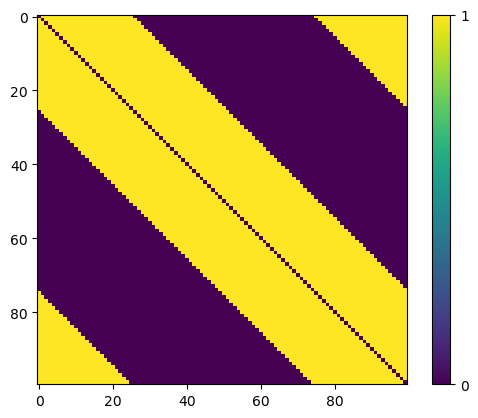

In [36]:
# construct the network and visualize 
A_ring = ring_graph(N, k)

# visualize the network adjacency matrix
plt.imshow(A_ring)
plt.colorbar(ticks=[0,1])
plt.show()

Now let's solve the Kuramoto model across a range of $\epsilon$ values. For each value of $\epsilon \in [-0.05,0.1]$, I compute the simulation 20 times (with different initial conditions) and average the order parameter across replications.

Note that I have also implemented parallelization (on the cpu) so that we can investigate the phase transition with a high level of detail and complete the computations in a reasonable amount of time.

In [39]:
n_epsilons = 150
sims_per_epsilon = 20
epsilons = np.linspace(-0.05, 0.08, n_epsilons)

def run_one_epsilon(eps, A):
    """
    Computes the order parameter for a given epsilon value. 
    We run the Kuramoto simulation sims_per_epsilon times (setting initial
    phases to random values each time) for a given epsilon and return the
    average order parameter at the final time step between runs.  
    """
    r_sum = 0.0
    for _ in range(sims_per_epsilon):
        # random initial phases in [-pi, pi]
        theta0 = np.random.uniform(-np.pi, np.pi, N)
        
        # run the simulation (for current epsilon and theta0)
        theta = km_simulation(A, omega, eps, theta0, t, dt)
        
        # measure final order parameter and add to running sum
        r_final = final_order_parameter(theta)
        r_sum += r_final
    
    return r_sum / sims_per_epsilon

results_ring = Parallel(n_jobs=-1, verbose=10)(
    delayed(run_one_epsilon)(e, A_ring) for e in epsilons
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 103 out of 150 | elapsed:  6.2min remaining:  2.8min
[Parallel(n_jobs=-1)]: Done 119 out of 150 | elapsed:  6.5min remaining:  1.7min
[Parallel(n_jobs=-1)]: Done 135 out of 150 | elapsed:  7.3min remaining:   48.4s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  7.6min finished


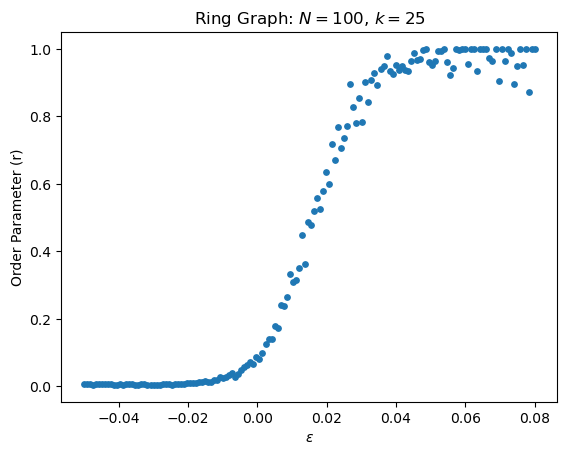

In [40]:
plt.scatter(epsilons, results_ring, s=15)
plt.xlabel('$\epsilon$')
plt.ylabel('Order Parameter (r)')
plt.title(f"Ring Graph: $N={N}$, $k={k}$")
plt.show()

Observe that we have consider how $r$ changes across both regimes of the order parameter. 

* $\epsilon > 0$: Attractive coupling, pulls states together, promotes synchronization
* $\epsilon < 0$ Repulsive coupling, pushes states apart, discourages synchronization

I have chosen this range of values through trial and error in order to center the phase transition. The small scatter among points reflects the variance due to the varying initial states. 


Note that the specific character of the phase transition depends on: 

1. For higher values of $N$, (provided that $k$ increases proportionally) we expect a "sharper" phase transition: the jump up to synchronization will happen over a narrower range of $\epsilon$ values. This is because as $N \rightarrow$ large, there is less of an effect on $r$ due to smaller groups of out-of-phase oscillators.

2. The location (in $\epsilon$ space) depends on how well connected the network is. In this case, we use $k=25$, meaning that each oscillator is quite well connected with it's neighbours. This causes the network to synchronize at a relatively small $\epsilon$. Intuitively, if we decrease $k$, we we reach synchronization at a higher value of $\epsilon$ as there is less interaction in the network. 

In [10]:
# compute degree of ring 
degree_ring = np.sum(A_ring, axis=1)
degree_ring.mean()

50.0

### **Small World**

Now we want to solve the Kuramoto model for the Small-World Network. I use the `networkx` implementation of the small world network and set the $k$ value to be twice that of the ring graph such that we get the same average network degree of 50.

Average degree of small world network: 50.0


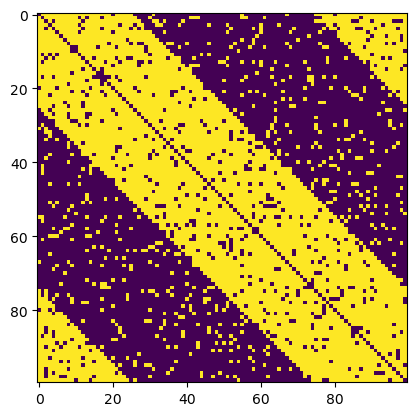

In [11]:
G_sw = nx.watts_strogatz_graph(n=100, k=2*k, p=0.1)
A_sw = nx.to_numpy_array(G_sw, dtype=bool)
plt.imshow(A_sw)
print(f"Average degree of small world network: {np.sum(A_sw, axis=1).mean()}")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 103 out of 150 | elapsed:  6.2min remaining:  2.8min
[Parallel(n_jobs=-1)]: Done 119 out of 150 | elapsed:  6.5min remaining:  1.7min
[Parallel(n_jobs=-1)]: Done 135 out of 150 | elapsed:  7.3min remaining:   48.6s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  7.6min finished


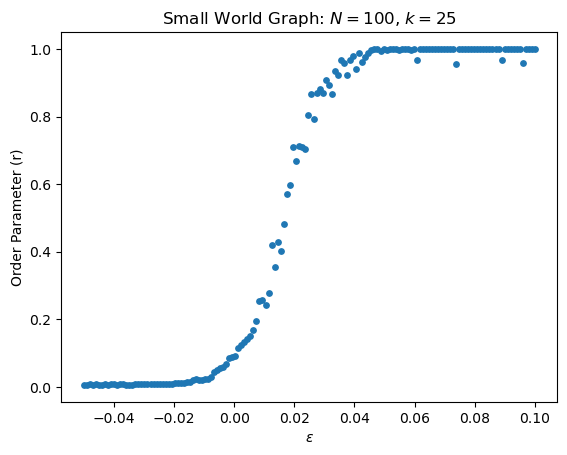

In [18]:
results_sw = Parallel(n_jobs=-1, verbose=10)(
    delayed(run_one_epsilon)(e, A_sw) for e in epsilons
)
plt.scatter(epsilons, results_sw, s=15)
plt.xlabel('$\epsilon$')
plt.ylabel('Order Parameter (r)')
plt.title(f"Small World Graph: $N={N}$, $k={k}$")
plt.show()

### Random-Graph

And now we can do the same analysis for the random graph. Note that I again set the probability of edge wiring such that the average node degree is also 50. 

Average degree of random network: 50.58


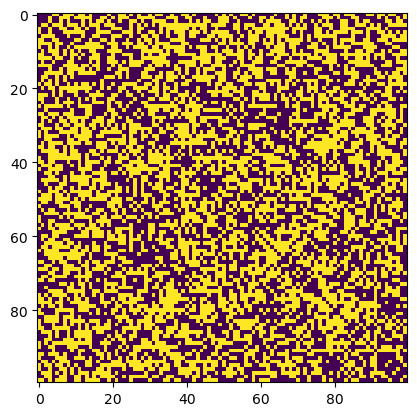

In [13]:
p_edge = 50/99.0
G_rand = nx.erdos_renyi_graph(n=100, p=p_edge)
A_rand = nx.to_numpy_array(G_rand, dtype=bool)
plt.imshow(A_rand)
print(f"Average degree of random network: {np.sum(A_rand, axis=1).mean()}")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 103 out of 150 | elapsed:  6.2min remaining:  2.8min
[Parallel(n_jobs=-1)]: Done 119 out of 150 | elapsed:  6.5min remaining:  1.7min
[Parallel(n_jobs=-1)]: Done 135 out of 150 | elapsed:  7.3min remaining:   48.8s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  7.7min finished


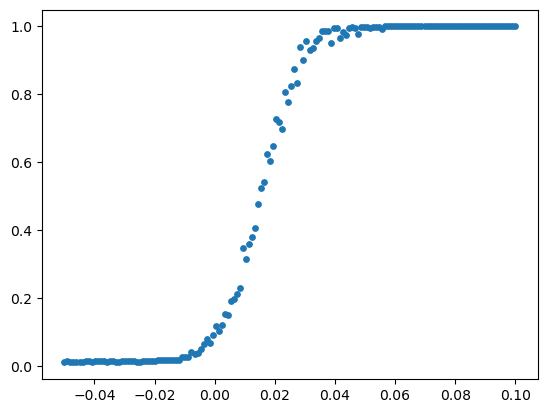

In [19]:
results_random = Parallel(n_jobs=-1, verbose=10)(
    delayed(run_one_epsilon)(e, A_rand) for e in epsilons
)
plt.scatter(epsilons, results_random, s=15)

## **Comparing Results**

Now we can compare results. Note that the results appear to be quite similar. 

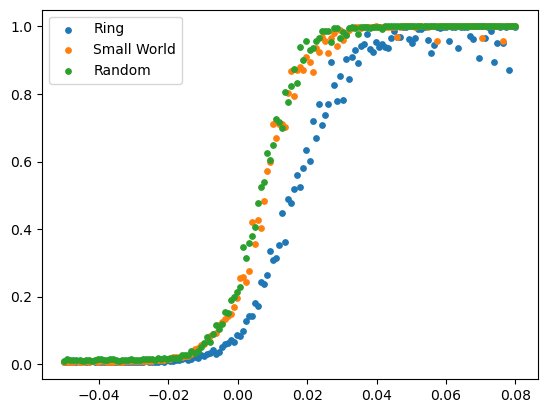

In [41]:
plt.scatter(epsilons, results_ring, s=15, label='Ring')
plt.scatter(epsilons, results_sw, s=15, label='Small World')
plt.scatter(epsilons, results_random, s=15, label='Random')
plt.legend()
plt.show()